# Vehicle Detection


In [37]:
# Imports 
import cv2
import glob
import time
import pickle
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split  # fro sklearn version >=0.18
from scipy.ndimage.measurements import label 
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline 

In [38]:
# Load training Data

car_images = glob.glob('dataset/vehicles/**/*.png')
noncar_images = glob.glob('dataset/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

8792 8968


## Convert Image to Histogram of gradients

In [10]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

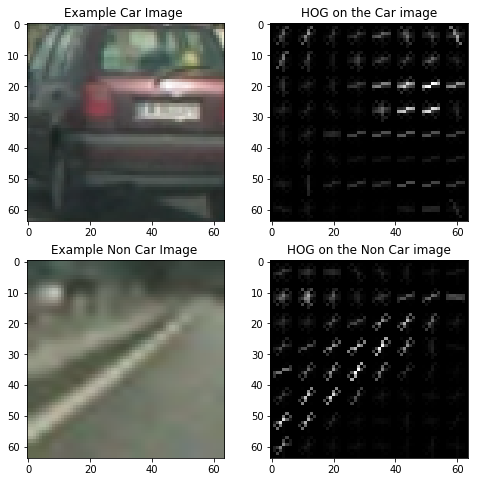

In [31]:
# Visualize an example image: 
example_car_img = mpimg.imread(car_images[2])
features,output_car = get_hog_features(example_car_img[:,:,2], 9, 8 , 8 , vis=True, feature_vec=True)
example_non_car_img = mpimg.imread(noncar_images[2])
features_nc,output_non_car = get_hog_features(example_non_car_img[:,:,2], 9, 8 , 8 , vis=True, feature_vec=True)

plt.figure(1, figsize=(8,8))
plt.subplot(221)
plt.imshow(example_car_img, cmap = 'gray')
plt.title('Example Car Image ')
plt.subplot(222)
plt.imshow(output_car, cmap = 'gray')
plt.title('HOG on the Car image')
plt.subplot(223)
plt.imshow(example_non_car_img, cmap = 'gray')
plt.title('Example Non Car Image ')
plt.subplot(224)
plt.imshow(output_non_car, cmap = 'gray')
plt.title('HOG on the Non Car image')

plt.show()


## Extract HOG features from an array of images

In [32]:
# Function to extract the features of all the images from an array 
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

## Processing the dataset 

In [36]:
# Parameters for features extraction
colorspace = 'RGB'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'

car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  
# Create an array stack of labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Data Divided in train and test, Feature and label vectors created')

Data Divided in train and test, Feature and label vectors created


## Training the Classifier

In [ ]:
# Using SVC linear Classifier
svc = LinearSVC()
# Fitting the data
svc.fit(X_train, y_train)
# Accuracy of the training
print('Training Accuracy: ', svc.score(X_train,y_train))
# Accuracy on Test Data
print('Test Accuracy: ', svc.score(X_test,y_test))

